In [508]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats

In [509]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped', '../data/spark.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [510]:
chroms = [str(x) for x in range(1, 23)] #+ 
#chroms = ['22']

ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'

#ihart_chip_family_sizes = [3, 4, 5, 6, 7]
#ihart_chip_phase_dir = '../phased_ihart_chip'

#ihart_quad_family_sizes = [4]
#ihart_quad_phase_dir = '../phased_ihart_quad'

ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc_9.10'

spark_family_sizes = [4, 5, 6]
spark_phase_dir = '../phased_spark'

#spark_quad_family_sizes = [4]
#spark_quad_phase_dir = '../phased_spark_quad'

In [511]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
#ok_ihart_quad_families = pull_ok_families(ihart_quad_phase_dir, ihart_quad_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)
ok_spark_families = pull_ok_families(spark_phase_dir, spark_family_sizes)
#ok_spark_quad_families = pull_ok_families(spark_quad_phase_dir, spark_quad_family_sizes)
#ok_ihart_chip_families = pull_ok_families(ihart_chip_phase_dir, ihart_chip_family_sizes)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 766
Counter({22: 766, 18: 41, 21: 24, 20: 17, 19: 11})
Families with LCL 12
Final families 765
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 519
Counter({22: 519})
Families with LCL 0
Final families 519
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 2226
Counter({22: 2226, 17: 305, 15: 286, 19: 205, 21: 93, 20: 31, 18: 25, 16: 3})
Families with LCL 0
Final families 2226


In [512]:
def load_phase_data(phase_dir, family_sizes, families_to_include, ignore_mask=False):
    sibpair_to_mat_match = defaultdict(int)
    sibpair_to_mat_mismatch = defaultdict(int)
    sibpair_to_pat_match = defaultdict(int)
    sibpair_to_pat_mismatch = defaultdict(int)

    for chrom in chroms:
        print(chrom, end=' ')

        # pull families
        family_to_individuals = dict()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f: 
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        family_to_individuals[family_key] = pieces[1:(1+j)]


        # now read phase info
        for j in family_sizes:
            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        length = end_pos - start_pos + 1

                        has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                        children = family_to_individuals[family_key][2:]
                        if inheritance_state[-1] == 0 or ignore_mask:
                            for i, child in enumerate(children):
                                if inheritance_state[4+(2*i)] == 0:
                                    has_m1.append(child)
                                elif inheritance_state[4+(2*i)] == 1:
                                    has_m2.append(child)
                                if inheritance_state[5+(2*i)] == 0:
                                    has_p1.append(child)
                                elif inheritance_state[5+(2*i)] == 1:
                                    has_p2.append(child)
                                    
                        # matches
                        for c1, c2 in combinations(has_m1, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_m2, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p1, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p2, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                            
                        # mismatches
                        for c1, c2 in product(has_m1, has_m2):
                            sibpair_to_mat_mismatch[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in product(has_p1, has_p2):
                            sibpair_to_pat_mismatch[(min(c1, c2), max(c1, c2))] += length
    return sibpair_to_mat_match, sibpair_to_mat_mismatch, sibpair_to_pat_match, sibpair_to_pat_mismatch

#print('iHART')
#ihart_sibpair_to_mat_match, ihart_sibpair_to_mat_mismatch, ihart_sibpair_to_pat_match, ihart_sibpair_to_pat_mismatch = load_phase_data(ihart_phase_dir, ihart_family_sizes, ok_ihart_families)#, ignore_mask=True)
#print('iHART quad')
#ihart_quad_sibpair_to_mat_match, ihart_quad_sibpair_to_mat_mismatch, ihart_quad_sibpair_to_pat_match, ihart_quad_sibpair_to_pat_mismatch = load_phase_data(ihart_quad_phase_dir, ihart_quad_family_sizes, ok_ihart_quad_families)#, ignore_mask=True)
#print('iHART chip')
#ihart_chip_sibpair_to_mat_match, ihart_chip_sibpair_to_mat_mismatch, ihart_chip_sibpair_to_pat_match, ihart_chip_sibpair_to_pat_mismatch  = load_phase_data(ihart_chip_phase_dir, ihart_chip_family_sizes, ok_ihart_chip_families)
#print('SSC')
#ssc_sibpair_to_mat_match, ssc_sibpair_to_mat_mismatch, ssc_sibpair_to_pat_match, ssc_sibpair_to_pat_mismatch  = load_phase_data(ssc_phase_dir, ssc_family_sizes, ok_ssc_families)#, ignore_mask=True)
print('Spark')
spark_sibpair_to_mat_match, spark_sibpair_to_mat_mismatch, spark_sibpair_to_pat_match, spark_sibpair_to_pat_mismatch  = load_phase_data(spark_phase_dir, spark_family_sizes, ok_spark_families)#, ignore_mask=True)
##print('Spark quad')
#spark_quad_sibpair_to_mat_match, spark_quad_sibpair_to_mat_mismatch, spark_quad_sibpair_to_pat_match, spark_quad_sibpair_to_pat_mismatch  = load_phase_data(spark_quad_phase_dir, spark_quad_family_sizes, ok_spark_quad_families)#, ignore_mask=True)



Spark
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [513]:
#ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_match.keys())) #& set(ihart_quad_sibpair_to_mat_match.keys()))
#ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_match.keys()) & set(ihart_quad_sibpair_to_mat_match.keys()) & set(ihart_chip_sibpair_to_mat_match.keys()))
#ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_match.keys()))# & set(ihart_chip_sibpair_to_mat_match.keys()))
#ssc_sibpairs = sorted(ssc_sibpair_to_mat_match.keys())
spark_sibpairs = sorted(set(spark_sibpair_to_mat_match.keys())) #& set(spark_quad_sibpair_to_mat_match.keys()))

#ihart_mat_match = np.array([ihart_sibpair_to_mat_match[k] for k in ihart_sibpairs])
#ihart_mat_mismatch = np.array([ihart_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
#ihart_pat_match = np.array([ihart_sibpair_to_pat_match[k] for k in ihart_sibpairs])
#ihart_pat_mismatch = np.array([ihart_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

#ihart_quad_mat_match = np.array([ihart_quad_sibpair_to_mat_match[k] for k in ihart_sibpairs])
#ihart_quad_mat_mismatch = np.array([ihart_quad_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
#ihart_quad_pat_match = np.array([ihart_quad_sibpair_to_pat_match[k] for k in ihart_sibpairs])
#ihart_quad_pat_mismatch = np.array([ihart_quad_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

#ihart_chip_mat_match = np.array([ihart_chip_sibpair_to_mat_match[k] for k in ihart_sibpairs])
#ihart_chip_mat_mismatch = np.array([ihart_chip_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
#ihart_chip_pat_match = np.array([ihart_chip_sibpair_to_pat_match[k] for k in ihart_sibpairs])
#ihart_chip_pat_mismatch = np.array([ihart_chip_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

#ssc_mat_match = np.array([ssc_sibpair_to_mat_match[k] for k in ssc_sibpairs])
#ssc_mat_mismatch = np.array([ssc_sibpair_to_mat_mismatch[k] for k in ssc_sibpairs])
#ssc_pat_match = np.array([ssc_sibpair_to_pat_match[k] for k in ssc_sibpairs])
#ssc_pat_mismatch = np.array([ssc_sibpair_to_pat_mismatch[k] for k in ssc_sibpairs])

spark_mat_match = np.array([spark_sibpair_to_mat_match[k] for k in spark_sibpairs])
spark_mat_mismatch = np.array([spark_sibpair_to_mat_mismatch[k] for k in spark_sibpairs])
spark_pat_match = np.array([spark_sibpair_to_pat_match[k] for k in spark_sibpairs])
spark_pat_mismatch = np.array([spark_sibpair_to_pat_mismatch[k] for k in spark_sibpairs])

#spark_quad_mat_match = np.array([spark_quad_sibpair_to_mat_match[k] for k in spark_sibpairs])
#spark_quad_mat_mismatch = np.array([spark_quad_sibpair_to_mat_mismatch[k] for k in spark_sibpairs])
#spark_quad_pat_match = np.array([spark_quad_sibpair_to_pat_match[k] for k in spark_sibpairs])
#spark_quad_pat_mismatch = np.array([spark_quad_sibpair_to_pat_mismatch[k] for k in spark_sibpairs])


In [514]:
# needs to be hand-tuned
def find_outliers(mat_match, mat_mismatch, pat_match, pat_mismatch):
    if chroms == ['X']:
        m = max(np.max(mat_match+mat_mismatch), np.max(pat_match+pat_mismatch))
        pat_ok = (pat_match < 0.1*m) | (pat_mismatch < 0.1*m)
        return ~pat_ok | (mat_match+mat_mismatch < 0.9*m) 
    else:
        m = max(np.max(mat_match+mat_mismatch), np.max(pat_match+pat_mismatch))
        return (mat_match+mat_mismatch < 0.9*m) | (pat_match+pat_mismatch < 0.9*m)  
    
#ihart_outliers = find_outliers(ihart_mat_match, ihart_mat_mismatch, ihart_pat_match, ihart_pat_mismatch)
#print('Removing %d outliers iHART' % np.sum(ihart_outliers))

#ihart_quad_outliers = find_outliers(ihart_quad_mat_match, ihart_quad_mat_mismatch, ihart_quad_pat_match, ihart_quad_pat_mismatch)
#print('Removing %d outliers iHART quad' % np.sum(ihart_quad_outliers))

#ihart_chip_outliers = find_outliers(ihart_chip_mat_match, ihart_chip_mat_mismatch, ihart_chip_pat_match, ihart_chip_pat_mismatch)
#print('Removing %d outliers iHART chip' % np.sum(ihart_chip_outliers))

#ssc_outliers = find_outliers(ssc_mat_match, ssc_mat_mismatch, ssc_pat_match, ssc_pat_mismatch)
#print('Removing %d outliers SSC' % np.sum(ssc_outliers))

spark_outliers = find_outliers(spark_mat_match, spark_mat_mismatch, spark_pat_match, spark_pat_mismatch)
print('Removing %d outliers spark' % np.sum(spark_outliers))

#spark_quad_outliers = find_outliers(spark_quad_mat_match, spark_quad_mat_mismatch, spark_quad_pat_match, spark_quad_pat_mismatch)
#print('Removing %d outliers spark quad' % np.sum(spark_quad_outliers))


Removing 64 outliers spark


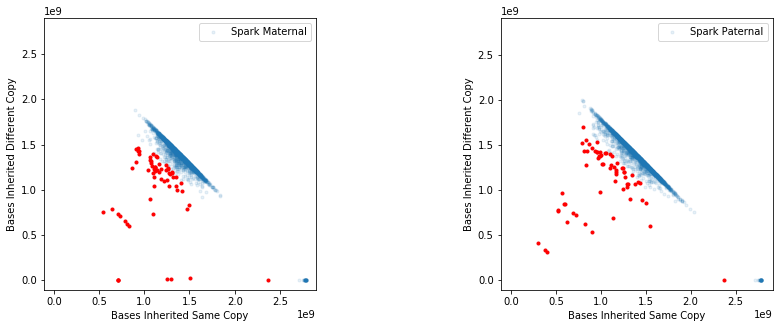

In [515]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
#plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
#plt.scatter(ihart_mat_match[ihart_outliers], ihart_mat_mismatch[ihart_outliers], color='red')

#plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
#plt.scatter(ihart_quad_mat_match[ihart_quad_outliers], ihart_quad_mat_mismatch[ihart_quad_outliers], color='red')

#plt.scatter(ihart_chip_mat_match, ihart_chip_mat_mismatch, alpha=0.1, label='iHART chip Maternal')
#plt.scatter(ihart_chip_mat_match[ihart_chip_outliers], ihart_chip_mat_mismatch[ihart_chip_outliers], color='red')

#plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')#plt.scatter(ssc_mat_match[ssc_outliers], ssc_mat_mismatch[ssc_outliers], color='red')
#plt.scatter(ssc_mat_match[ssc_outliers], ssc_mat_mismatch[ssc_outliers], color='red')

plt.scatter(spark_mat_match, spark_mat_mismatch, alpha=0.1, label='Spark Maternal', marker='.')
plt.scatter(spark_mat_match[spark_outliers], spark_mat_mismatch[spark_outliers], color='red', marker='.')#

#plt.scatter(spark_quad_mat_match, spark_quad_mat_mismatch, alpha=0.1, label='Spark quad Maternal')
#plt.scatter(spark_quad_mat_match[spark_quad_outliers], spark_quad_mat_mismatch[spark_quad_outliers], color='red')

plt.legend()
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.xlim([plt.ylim()[0], None])
plt.ylim(plt.xlim())
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 2, 2)

#plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')
#plt.scatter(ihart_pat_match[ihart_outliers], ihart_pat_mismatch[ihart_outliers], color='red')

#plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')
#plt.scatter(ihart_quad_pat_match[ihart_quad_outliers], ihart_quad_pat_mismatch[ihart_quad_outliers], color='red')

#plt.scatter(ihart_chip_pat_match, ihart_chip_pat_mismatch, alpha=0.1, label='iHART chip Paternal')
#plt.scatter(ihart_chip_pat_match[ihart_chip_outliers], ihart_chip_pat_mismatch[ihart_chip_outliers], color='red')

#plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')
#plt.scatter(ssc_pat_match[ssc_outliers], ssc_pat_mismatch[ssc_outliers], color='red')

plt.scatter(spark_pat_match, spark_pat_mismatch, alpha=0.1, label='Spark Paternal', marker='.')
plt.scatter(spark_pat_match[spark_outliers], spark_pat_mismatch[spark_outliers], color='red', marker='.')

#plt.scatter(spark_quad_pat_match, spark_quad_pat_mismatch, alpha=0.1, label='Spark quad Paternal')
#plt.scatter(spark_quad_pat_match[spark_quad_outliers], spark_quad_pat_mismatch[spark_quad_outliers], color='red')

plt.legend()
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.xlim([plt.ylim()[0], None])
plt.ylim(plt.xlim())
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [516]:
#ihart_indices = ~ihart_outliers & ~ihart_quad_outliers & ~ihart_chip_outliers
#ihart_indices = ~ihart_outliers #& ~ihart_quad_outliers
#ihart_indices = ~ihart_outliers #& ~ihart_chip_outliers
#ssc_indices = ~ssc_outliers
spark_indices = ~spark_outliers #& ~spark_quad_outliers

#ihart_sibpairs = [ihart_sibpairs[i] for i in np.where(ihart_indices)[0]]
#ssc_sibpairs = [ssc_sibpairs[i] for i in np.where(ssc_indices)[0]]
spark_sibpairs = [spark_sibpairs[i] for i in np.where(spark_indices)[0]]

#ihart_mat_match = ihart_mat_match[ihart_indices]
#ihart_mat_mismatch = ihart_mat_mismatch[ihart_indices]
#ihart_pat_match = ihart_pat_match[ihart_indices]
#ihart_pat_mismatch = ihart_pat_mismatch[ihart_indices]

#ihart_quad_mat_match = ihart_quad_mat_match[ihart_indices]
#ihart_quad_mat_mismatch = ihart_quad_mat_mismatch[ihart_indices]
#ihart_quad_pat_match = ihart_quad_pat_match[ihart_indices]
#ihart_quad_pat_mismatch = ihart_quad_pat_mismatch[ihart_indices]

#ihart_chip_mat_match = ihart_chip_mat_match[ihart_indices]
#ihart_chip_mat_mismatch = ihart_chip_mat_mismatch[ihart_indices]
#ihart_chip_pat_match = ihart_chip_pat_match[ihart_indices]
#ihart_chip_pat_mismatch = ihart_chip_pat_mismatch[ihart_indices]

#ssc_mat_match = ssc_mat_match[ssc_indices]
#ssc_mat_mismatch = ssc_mat_mismatch[ssc_indices]
#ssc_pat_match = ssc_pat_match[ssc_indices]
#ssc_pat_mismatch = ssc_pat_mismatch[ssc_indices]

spark_mat_match = spark_mat_match[spark_indices]
spark_mat_mismatch = spark_mat_mismatch[spark_indices]
spark_pat_match = spark_pat_match[spark_indices]
spark_pat_mismatch = spark_pat_mismatch[spark_indices]

#spark_quad_mat_match = spark_quad_mat_match[spark_indices]
#spark_quad_mat_mismatch = spark_quad_mat_mismatch[spark_indices]
#spark_quad_pat_match = spark_quad_pat_match[spark_indices]
#spark_quad_pat_mismatch = spark_quad_pat_mismatch[spark_indices]

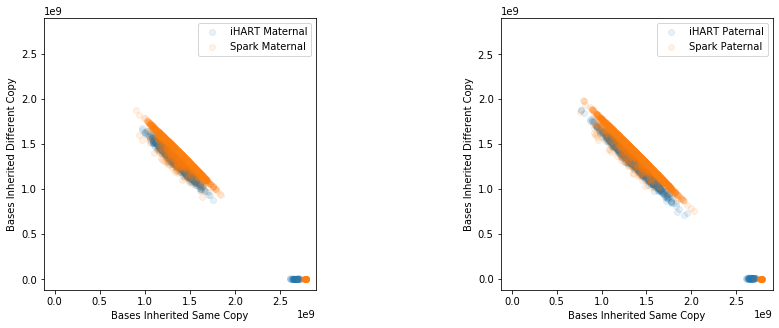

In [517]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
#plt.scatter(ihart_chip_mat_match, ihart_chip_mat_mismatch, alpha=0.1, label='iHART chip Maternal')
#plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
#plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')
plt.scatter(spark_mat_match, spark_mat_mismatch, alpha=0.1, label='Spark Maternal')
#plt.scatter(spark_quad_mat_match, spark_quad_mat_mismatch, alpha=0.1, label='Spark Maternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.legend()
plt.xlim([plt.ylim()[0], None])
plt.ylim(plt.xlim())
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 2, 2)
plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')
#plt.scatter(ihart_chip_pat_match, ihart_chip_pat_mismatch, alpha=0.1, label='iHART chip Paternal')
#plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')
#plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')
plt.scatter(spark_pat_match, spark_pat_mismatch, alpha=0.1, label='Spark Paternal')
#plt.scatter(spark_quad_pat_match, spark_quad_pat_mismatch, alpha=0.1, label='Spark Paternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.legend()
plt.xlim([plt.ylim()[0], None])
plt.ylim(plt.xlim())
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [518]:
#ihart_mat = ihart_mat_match/(ihart_mat_match+ihart_mat_mismatch)
#ihart_pat = ihart_pat_match/(ihart_pat_match+ihart_pat_mismatch)

#ihart_quad_mat = ihart_quad_mat_match/(ihart_quad_mat_match+ihart_quad_mat_mismatch)
#ihart_quad_pat = ihart_quad_pat_match/(ihart_quad_pat_match+ihart_quad_pat_mismatch)

#ihart_chip_mat = ihart_chip_mat_match/(ihart_chip_mat_match+ihart_chip_mat_mismatch)
#ihart_chip_pat = ihart_chip_pat_match/(ihart_chip_pat_match+ihart_chip_pat_mismatch)

#ssc_mat = ssc_mat_match/(ssc_mat_match+ssc_mat_mismatch)
#ssc_pat = ssc_pat_match/(ssc_pat_match+ssc_pat_mismatch)

spark_mat = spark_mat_match/(spark_mat_match+spark_mat_mismatch)
spark_pat = spark_pat_match/(spark_pat_match+spark_pat_mismatch)

#spark_quad_mat = spark_quad_mat_match/(spark_quad_mat_match+spark_quad_mat_mismatch)
#spark_quad_pat = spark_quad_pat_match/(spark_quad_pat_match+spark_quad_pat_mismatch)

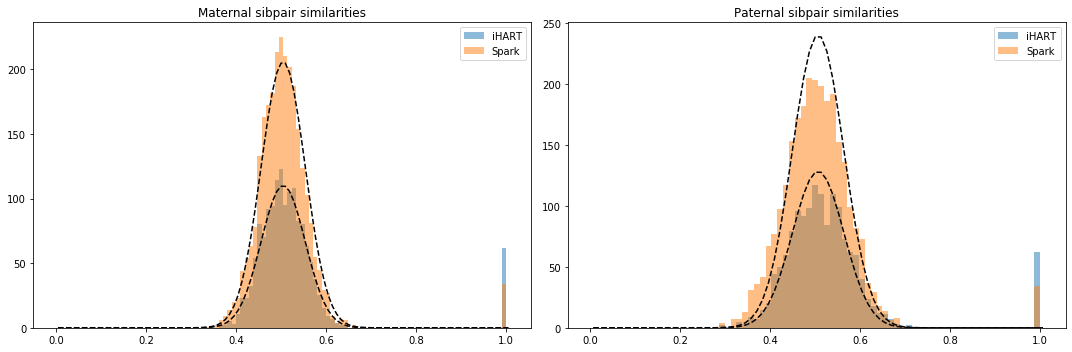

In [519]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n+1)
plt.plot((x_axis+0.5)/n, len([x for x in ihart_mat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
#plt.plot((x_axis+0.5)/n, len([x for x in ihart_chip_mat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
#plt.plot((x_axis+0.5)/n, len([x for x in ssc_mat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len([x for x in spark_mat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
#plt.hist(ihart_chip_mat, bins=x_axis/n, alpha=0.5, label='iHART chip')
#plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.hist(spark_mat, bins=x_axis/n, alpha=0.5, label='Spark')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
n = (21+(2*28))
x_axis = np.arange(0, n+1)
plt.plot((x_axis+0.5)/n, len([x for x in ihart_pat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
#plt.plot((x_axis+0.5)/n, len([x for x in ihart_chip_pat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
#plt.plot((x_axis+0.5)/n, len([x for x in ssc_pat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len([x for x in spark_pat if x < 0.95])*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
#plt.hist(ihart_chip_pat, bins=x_axis/n, alpha=0.5, label='iHART chip')
#plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.hist(spark_pat, bins=x_axis/n, alpha=0.5, label='Spark')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

In [520]:
#ihart_aut_aut_indices = np.array([child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='2' for x in ihart_sibpairs])
#ihart_aut_typ_indices = np.array([(child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='1') or (child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='2') for x in ihart_sibpairs])
#ihart_typ_typ_indices = np.array([child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='1' for x in ihart_sibpairs])

#ssc_aut_aut_indices = np.array([child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='2' for x in ssc_sibpairs])
#ssc_aut_typ_indices = np.array([(child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='1') or (child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='2') for x in ssc_sibpairs])
#ssc_typ_typ_indices = np.array([child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='1' for x in ssc_sibpairs])

spark_aut_aut_indices = np.array([child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='2' for x in spark_sibpairs])
spark_aut_typ_indices = np.array([(child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='1') or (child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='2') for x in spark_sibpairs])
spark_typ_typ_indices = np.array([child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='1' for x in spark_sibpairs])

print('iHART', 'aut-aut', np.sum(ihart_aut_aut_indices), 'aut-typ', np.sum(ihart_aut_typ_indices), 'typ-typ', np.sum(ihart_typ_typ_indices))
#print('SSC', 'aut-aut', np.sum(ssc_aut_aut_indices), 'aut-typ', np.sum(ssc_aut_typ_indices), 'typ-typ', np.sum(ssc_typ_typ_indices))
print('SPARK', 'aut-aut', np.sum(spark_aut_aut_indices), 'aut-typ', np.sum(spark_aut_typ_indices), 'typ-typ', np.sum(spark_typ_typ_indices))




iHART aut-aut 873 aut-typ 585 typ-typ 20
SPARK aut-aut 0 aut-typ 0 typ-typ 0


Ks_2sampResult(statistic=0.04350231777240425, pvalue=0.5236758875001107)
Ks_2sampResult(statistic=0.06482160016050179, pvalue=0.1093071054460023)


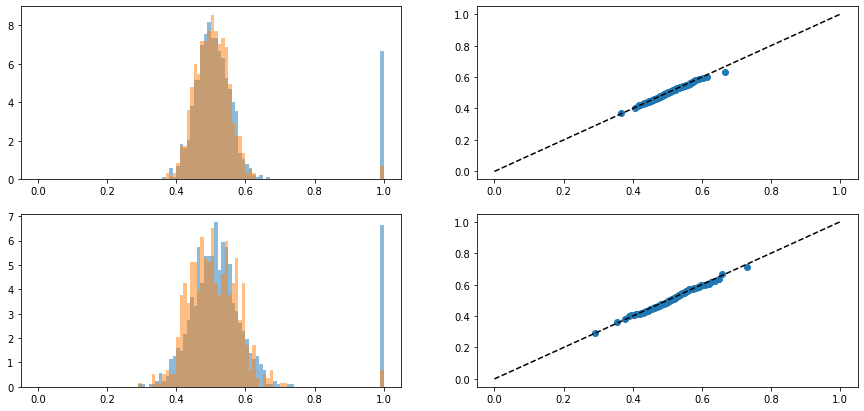

In [521]:
plt.figure(figsize=(15, 7))

bins = np.arange(0, 1.01, 0.01)

is_twin = (ihart_mat > 0.95) & (ihart_pat > 0.95)

plt.subplot(2, 2, 1)
plt.hist(ihart_mat[ihart_aut_aut_indices], bins=bins, density=True, alpha=0.5)
plt.hist(ihart_mat[ihart_aut_typ_indices], bins=bins, density=True, alpha=0.5)
#plt.hist(ssc_mat[ssc_aut_typ_indices], bins=bins, density=True, alpha=0.5)

plt.subplot(2, 2, 2)
plt.scatter(np.quantile(ihart_mat[ihart_aut_aut_indices & ~is_twin], bins), 
            np.quantile(ihart_mat[ihart_aut_typ_indices & ~is_twin], bins))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

print(stats.ks_2samp(ihart_mat[ihart_aut_aut_indices & ~is_twin], 
                     ihart_mat[ihart_aut_typ_indices & ~is_twin]))

plt.subplot(2, 2, 3)
plt.hist(ihart_pat[ihart_aut_aut_indices], bins=bins, density=True, alpha=0.5)
plt.hist(ihart_pat[ihart_aut_typ_indices], bins=bins, density=True, alpha=0.5)
#plt.hist(ssc_mat[ssc_aut_typ_indices], bins=bins, density=True, alpha=0.5)

plt.subplot(2, 2, 4)
plt.scatter(np.quantile(ihart_pat[ihart_aut_aut_indices & ~is_twin], bins), 
            np.quantile(ihart_pat[ihart_aut_typ_indices & ~is_twin], bins))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

print(stats.ks_2samp(ihart_pat[ihart_aut_aut_indices & ~is_twin], 
                     ihart_pat[ihart_aut_typ_indices & ~is_twin]))

plt.show()

In [522]:
sibpair_to_index = dict([(x, i) for i, x in enumerate(ihart_sibpairs)])
old_scores = np.zeros((len(ihart_sibpairs), 2))
old_scores[:] = np.nan
with open('../sibpair_similarity/sibpair_similarity_scores_full_genome.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if (pieces[0], pieces[1]) in sibpair_to_index:
            old_scores[sibpair_to_index[(pieces[0], pieces[1])], :] = float(pieces[3]), float(pieces[4])

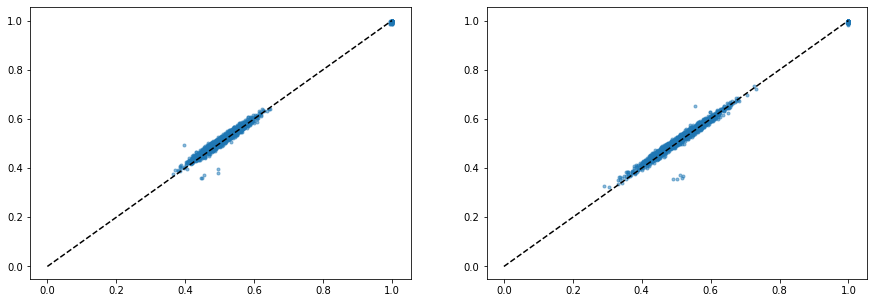

In [523]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat, old_scores[:, 0], alpha=0.5, marker='.')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.subplot(1, 2, 2)
plt.scatter(ihart_pat, old_scores[:, 1], alpha=0.5, marker='.')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')


In [524]:
print([ihart_sibpairs[i] for i in np.where(np.abs(ihart_mat-old_scores[:, 0])>0.05)[0]])
print([ihart_sibpairs[i] for i in np.where(np.abs(ihart_pat-old_scores[:, 1])>0.05)[0]])

[('AU0866301', 'AU0866302'), ('AU0905301', 'AU0905302'), ('AU0905301', 'AU0905303'), ('AU0905302', 'AU0905303'), ('AU0923301', 'AU0923302'), ('AU0941301', 'AU0941302')]
[('AU0866301', 'AU0866302'), ('AU0905301', 'AU0905302'), ('AU0905301', 'AU0905303'), ('AU0905302', 'AU0905303'), ('AU0923301', 'AU0923302'), ('AU0941301', 'AU0941302')]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [525]:
sibpair_to_index = dict([(x, i) for i, x in enumerate(spark_sibpairs)])
old_scores = np.zeros((len(spark_sibpairs), 2))
old_scores[:] = np.nan
with open('../sibpair_similarity/sibpair_similarity_scores_full_genome.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if (pieces[0], pieces[1]) in sibpair_to_index:
            old_scores[sibpair_to_index[(pieces[0], pieces[1])], :] = float(pieces[3]), float(pieces[4])

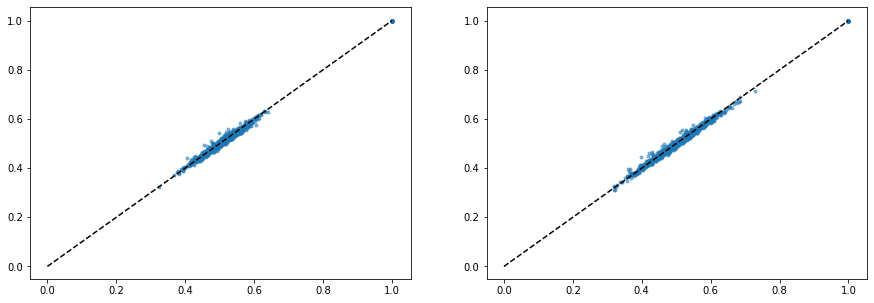

In [526]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(spark_mat, old_scores[:, 0], alpha=0.5, marker='.')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.subplot(1, 2, 2)
plt.scatter(spark_pat, old_scores[:, 1], alpha=0.5, marker='.')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')


In [527]:
print([spark_sibpairs[i] for i in np.where(np.abs(spark_mat-old_scores[:, 0])>0.2)[0]])
print([spark_sibpairs[i] for i in np.where(np.abs(spark_pat-old_scores[:, 1])>0.2)[0]])

[]
[]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [474]:
print([(spark_sibpairs[i], spark_mat[i], spark_pat[i]) for i in np.where(np.abs(spark_mat-old_scores[:, 0])>0.2)[0]])

[(('SF0039557_SP0039557', 'SF0039557_SP0039558'), 0.9807393248321395, 0.37282044875814135)]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat, ihart_chip_mat, alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('Maternal')
plt.xlabel('iHART sibpair similarity')
plt.ylabel('iHART chip sibpair similarity')
print(stats.pearsonr(ihart_mat, ihart_chip_mat))

plt.subplot(1, 2, 2)
plt.scatter(ihart_pat, ihart_chip_pat, alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('Paternal')
plt.xlabel('iHART sibpair similarity')
plt.ylabel('iHART chip sibpair similarity')
print(stats.pearsonr(ihart_mat, ihart_chip_mat))

plt.tight_layout()
plt.show()

In [ ]:
# write to file

with open('sibpair_similarity_scores%s_full_genome.txt' % ('X' if chroms==['X'] else ''), 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\tMat-Bases-Match\tMat-Bases-Mismatch\tPat-Bases-Match\tPat-Bases-Mismatch\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat[i], ssc_pat[i], ssc_mat_match[i], ssc_mat_mismatch[i], ssc_pat_match[i], ssc_pat_mismatch[i]))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'iHART', ihart_mat[i], ihart_pat[i], ihart_mat_match[i], ihart_mat_mismatch[i], ihart_pat_match[i], ihart_pat_mismatch[i]))
    for i, sibpair in enumerate(spark_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'Spark', spark_mat[i], spark_pat[i], spark_mat_match[i], spark_mat_mismatch[i], spark_pat_match[i], spark_pat_mismatch[i]))
    

In [ ]:
# write to file

with open('sibpair_similarity_scores%s_full_genome_quad.txt' % ('X' if chroms==['X'] else ''), 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\tMat-Bases-Match\tMat-Bases-Mismatch\tPat-Bases-Match\tPat-Bases-Mismatch\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat[i], ssc_pat[i], ssc_mat_match[i], ssc_mat_mismatch[i], ssc_pat_match[i], ssc_pat_mismatch[i]))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'iHARTquad', ihart_quad_mat[i], ihart_quad_pat[i], ihart_quad_mat_match[i], ihart_quad_mat_mismatch[i], ihart_quad_pat_match[i], ihart_quad_pat_mismatch[i]))
    for i, sibpair in enumerate(spark_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\t%d\t%d\t%d\t%d\n' % (sibpair[0], sibpair[1], 'Sparkquad', spark_quad_mat[i], spark_quad_pat[i], spark_quad_mat_match[i], spark_quad_mat_mismatch[i], spark_quad_pat_match[i], spark_quad_pat_mismatch[i]))
    